## G Colab

In [5]:
colab_env = False

In [ ]:
print('Mounting Gdrive')
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/')


colab_env = True

## Lib

In [6]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

from utils.import_df import import_df
from utils.file_processing import check_if_file_exists
from utils.img_preprocessing import get_features_target, img_preprocessing, generate_dataset

## Vars

In [8]:
if colab_env == True:
    csv_url = "/content/drive/MyDrive/ml_projects/mushroom-project/storage/datas/csv/clean/cleaned_dataset_with_features_and_dimensions_top_10_species.csv"
    img_directory = "/content/drive/MyDrive/ml_projects/mushroom-project/storage/datas/imgs/cleaned_dataset/"
    path_save_dataset = "/content/drive/MyDrive/ml_projects/mushroom-project/storage/datas/tf_datasets/"

else:
    csv_url = "../../storage/datas/csv/clean/cleaned_dataset_with_features_and_dimensions_top_10_species.csv"
    img_directory = "../../storage/datas/imgs/cleaned_dataset/"
    path_save_dataset = "../../storage/datas/tf_datasets/"

## 1 - import DF

### Full Dataset

In [9]:
# Full Dataset
df = import_df(csv_url)

DF loaded with shape: (12579, 16)
Unique species in DF: 10


In [10]:
df["species"].value_counts()

species
Pleurotus ostreatus      1541
Trametes versicolor      1537
Lepista nuda             1351
Boletus edulis           1322
Hypholoma fasciculare    1236
Pluteus cervinus         1234
Ganoderma applanatum     1137
Psilocybe cyanescens     1132
Galerina marginata       1115
Psilocybe zapotecorum     974
Name: count, dtype: int64

In [11]:
# Add image_path column & reload
df["image_path"] = df["image_lien"].apply(lambda x: os.path.join(img_directory, x))
df.to_csv(csv_url, index=False)
df = import_df(csv_url)

DF loaded with shape: (12579, 16)
Unique species in DF: 10


In [12]:
# Adapt image_path
df.drop(columns=['image_path'], inplace=True)
df["image_path"] = df["image_lien"].apply(lambda x: os.path.join(img_directory, x))

### Sample

In [13]:
# 10% Sample
df_sample_10 = import_df(csv_url,
                         sample = True,
                         sample_size = 0.1,
                         random_state=1)

DF sampled with 10.0% from original dataset, shape: (1258, 16)
Unique species in sampled DF: 10


In [14]:
df_sample_10["species"].value_counts()

species
Pleurotus ostreatus      168
Boletus edulis           131
Trametes versicolor      131
Lepista nuda             130
Pluteus cervinus         130
Ganoderma applanatum     124
Hypholoma fasciculare    121
Galerina marginata       119
Psilocybe cyanescens     114
Psilocybe zapotecorum     90
Name: count, dtype: int64

In [15]:
# Adapt image_path
df_sample_10.drop(columns=['image_path'], inplace=True)
df_sample_10["image_path"] = df_sample_10["image_lien"].apply(lambda x: os.path.join(img_directory, x))

## 2 - Check if all image files exist

In [16]:
check_if_file_exists(img_directory,
                     csv_url,
                     column = "image_path",
                     auto_clean_csv=False)

## 3 - Df column selection

In [17]:
target_column = "species"
img_link_column = "image_path"

In [18]:
df = df[[target_column, img_link_column]]
df_sample_10 = df_sample_10[[target_column, img_link_column]]

## 4 - Features & Targets

### Features & Targets generation

In [19]:
# Get features & target
df_features, df_target = get_features_target(df, target_column_name = "species")
df_sample_10_features, df_sample_10_target = get_features_target(df_sample_10, target_column_name = "species")

### Img Load & Preprocessing

2024-04-25 10:30:30.097529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 10:30:30.245580: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


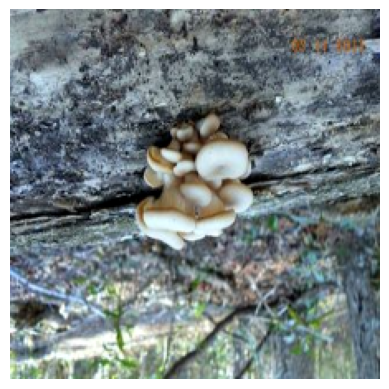

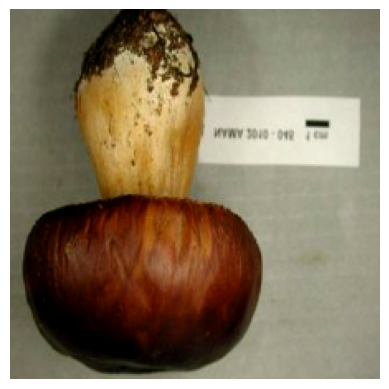

In [20]:
# Try random images pre-processing
n_random = 2
random_images = df_features["image_path"].sample(n_random)

img_preprocessing_args = {
    "dimensions": (224,224),
    "resize": True,
    "augment": True,
    "normalize": True,
    "flip_left_right": True,
    "flip_up_down": True,
    "brightness": True,
    "contrast": True,
    "saturation": False,
}

for elt in random_images:
    img = img_preprocessing(elt, **img_preprocessing_args)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Tensorflow dataset generation

#### Sample datasets

In [21]:
train_dataset, val_dataset, test_dataset = generate_dataset(df_sample_10_target, df_sample_10_features["image_path"],
                                                            train_size = 0.8, test_size = 0.5, random_state = 10,
                                                            img_dimensions = (224,224), resize = True,
                                                            augment = True, normalize = True,
                                                            flip_left_right = True,
                                                            flip_up_down = True,
                                                            brightness = True,
                                                            contrast = True,
                                                            saturation = False,
                                                            batch_size = 32)

Encoded target: [8 4 1 ... 2 7 9]
Label mapping: {'Boletus edulis': 0, 'Galerina marginata': 1, 'Ganoderma applanatum': 2, 'Hypholoma fasciculare': 3, 'Lepista nuda': 4, 'Pleurotus ostreatus': 5, 'Pluteus cervinus': 6, 'Psilocybe cyanescens': 7, 'Psilocybe zapotecorum': 8, 'Trametes versicolor': 9}
Train, validation & test splits created successfully.

 Current shapes: 
 X_train: (1006,) 
 X_val: (126,) 
 X_test: (126,) 
Train dataset generated successfully. Number of batches: 158
Validation dataset generated successfully. Number of batches: 20
Test dataset generated successfully. Number of batches: 4


#### Full datasets

In [22]:
train_dataset, val_dataset, test_dataset = generate_dataset(df_target, df_features["image_path"],
                                                            train_size = 0.8, test_size = 0.5, random_state = 10,
                                                            img_dimensions = (224,224), resize = True,
                                                            augment = True, normalize = True,
                                                            flip_left_right = True,
                                                            flip_up_down = True,
                                                            brightness = True,
                                                            contrast = True,
                                                            saturation = False,
                                                            batch_size = 32)

Encoded target: [9 9 9 ... 4 4 0]
Label mapping: {'Boletus edulis': 0, 'Galerina marginata': 1, 'Ganoderma applanatum': 2, 'Hypholoma fasciculare': 3, 'Lepista nuda': 4, 'Pleurotus ostreatus': 5, 'Pluteus cervinus': 6, 'Psilocybe cyanescens': 7, 'Psilocybe zapotecorum': 8, 'Trametes versicolor': 9}
Train, validation & test splits created successfully.

 Current shapes: 
 X_train: (10063,) 
 X_val: (1258,) 
 X_test: (1258,) 
Train dataset generated successfully. Number of batches: 1573
Validation dataset generated successfully. Number of batches: 200
Test dataset generated successfully. Number of batches: 40


#### Save Datasets

In [23]:
# Train dataset
path_save_train_dataset = os.path.join(path_save_dataset, "train_dataset")
tf.data.Dataset.save(train_dataset, path_save_train_dataset)

: 

In [28]:
# Val dataset
path_save_val_dataset = os.path.join(path_save_dataset, "val_dataset")
tf.data.Dataset.save(val_dataset, path_save_val_dataset)

In [27]:
# Test dataset
path_save_test_dataset = os.path.join(path_save_dataset, "test_dataset")
tf.data.Dataset.save(test_dataset, path_save_test_dataset)